# Proof of Concept
******
## Overview
In this section, we will provide a demo of our system.  

For easier reference, the outline of the steps taken in this notebook is as follows:
##### Steps:
1. Import and Install Required Libraries
2. Loading Training and Testing Datasets
3. Data Exploration
4. Data Pre-processing
5. Setting Up the Model
6. Model Evaluation
7. Model Predictions

The first step for this Proof of Concept (POC) will be to import and install required libraries. This will allow us to perform important tasks across this POC such as data preprocessing, data visualisation, the creation of deep learning models and model evaluation. The first step also involves initialising any variables that we may need across multiple parts of the code. Next, we are required to load the data used to train and validate the predictions given by the model. Training datasets are categorised into two types, *unperturbed* and *perturbed*. The *perturbed* training dataset contains the images from the *unpertubed* dataset with digital makeup on. <br>
...
***************

## Step 1: Import and Install Required Libraries

In [11]:
# %pip install opencv-python
# %pip install matplotlib
# %pip install keras
# %pip install seaborn
# %pip install sklearn

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import cv2
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
import seaborn as sns
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from ipykernel import kernelapp as app

In [35]:
epochs = 200
img_size = 224
labels = ['female', 'male']

******************
## Step 2: Load Training and Testing Datasets

In [4]:
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [9]:
train = get_data('preprocessing/train_data')
val = get_data('preprocessing/val_data')
train_pert = get_data('preprocessing/makeup')

/home/monash/.pyenv/versions/3.6.13/envs/fyp/lib/python3.6/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


*********************
## Step 3: Data Exploration

/home/monash/.pyenv/versions/3.6.13/envs/fyp/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


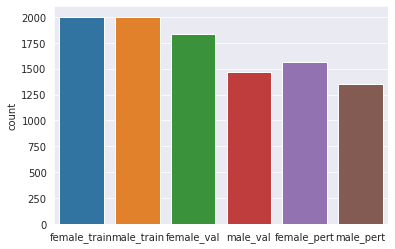

In [19]:
l = []
train_count = 0
val_count = 0
train_pert_count = 0
for i in train:
    if(i[1] == 0):
        l.append("female_train")
    else:
        l.append("male_train")
    train_count +=1
    
for j in val:
    if(j[1] == 0):
        l.append("female_val")
    else:
        l.append("male_val")
    val_count += 1

for j in train_pert:
    if(j[1] == 0):
        l.append("female_pert")
    else:
        l.append("male_pert")
    train_pert_count += 1
    
sns.set_style('darkgrid')
g = sns.countplot(l)

**********************
## Step 4: Data Pre-processing

In [11]:
x_train = []
y_train = []
x_train_pert = []
y_train_pert = []
x_val = []
y_val = []

# Unpertubed Dataset
for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
x_train = np.array(x_train) / 255
x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

# Perturbed Dataset
for feature, label in train_pert:
    x_train_pert.append(feature)
    y_train_pert.append(label)
x_train_pert = np.array(x_train_pert) / 255
x_train_pert.reshape(-1, img_size, img_size, 1)
y_train_pert = np.array(y_train_pert)

# Validation Dataset
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)
x_val = np.array(x_val) / 255
x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

**********************
## Step 5: Setting Up the Model
- Explain layer by layer
    - number of epochs, batch size
    - activation functions
    - dropout to reduce overfitting
    - why it is best practice for later layers to have an increasing amount of filters

### Without Pertubations

In [36]:
model = Sequential()

# Convolutional layer 1
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2,2), strides=2))

# Convolutional layer 2
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(2, activation="softmax"))

model.summary()
#-----------------------------------------------------------------
opt = Adam(lr=0.000001)
model.compile(optimizer = opt , 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics = ['accuracy'])
#------------------------------------------------------------------
# early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, mode='min', verbose=1)
checkpoint = ModelCheckpoint('model_best_weights.h5', monitor='loss', verbose=1, # Saves checkpoints
                             save_best_only=True, mode='min', save_freq='epoch')


history = model.fit(x_train,y_train,epochs = epochs , 
                    validation_data = (x_val, y_val), 
                    callbacks = [checkpoint])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                

### With Pertubations

In [37]:
model_pert = Sequential()

model_pert.add(Conv2D(32, 3, 3, padding="same", activation="relu", input_shape=(224,224,3)))
model_pert.add(MaxPool2D())

model_pert.add(Conv2D(64, 3, 3, padding="same", activation="relu"))
model_pert.add(MaxPool2D())
model_pert.add(Dropout(0.4))

model_pert.add(Flatten())
model_pert.add(Dense(2, activation="softmax"))

model_pert.summary()
#-----------------------------------------------------------------
opt = Adam(lr=0.000001)
model_pert.compile(optimizer = opt , 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics = ['accuracy'])
#------------------------------------------------------------------
# early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, mode='min', verbose=1)
checkpoint = ModelCheckpoint('model_best_weights_pert.h5', monitor='loss', verbose=1, # Saves checkpoints
                             save_best_only=True, mode='min', save_freq='epoch')

history_pert = model_pert.fit(x_train,y_train,epochs = epochs , 
                    validation_data = (x_val, y_val), 
                    callbacks = [checkpoint])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 75, 75, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

********
## Step 6: Model Evaluation and Predictions

Discussion points:
- Compare Accuracy and Loss
- Compare Confusion Matrices
- Why the precision, recall and f1-score are similar when the data is unpertubated.
- Why the recall is so consistently high when the data is pertubated.


### Without Pertubation

#### Accuracy and Loss

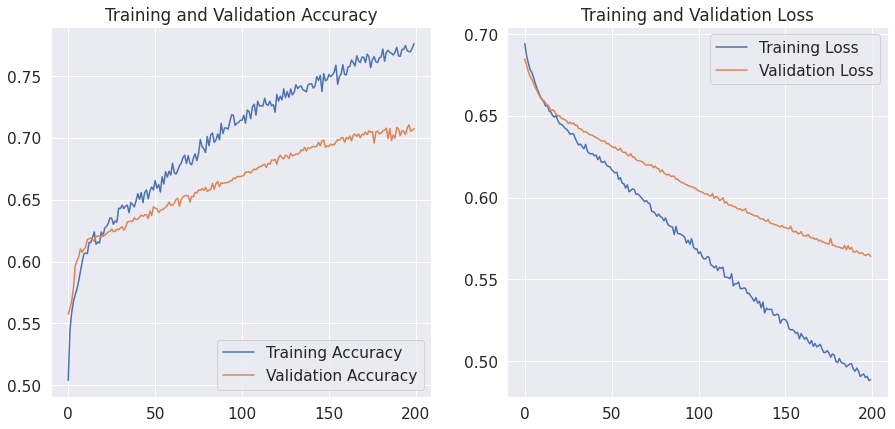

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Confusion Matrix

In [39]:
num_of_train_samples = train_count
num_of_test_samples = val_count
test_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = test_datagen.flow_from_directory("preprocessing/val_data",
                                                        target_size=(224, 224),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')
Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
confusion_matrix_array = confusion_matrix(validation_generator.classes, y_pred)
print(confusion_matrix_array)
df_cm = pd.DataFrame(confusion_matrix_array, range(2), range(2))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

### Classification Report

In [43]:
predictions = model.predict_classes(x_val)
predictions = predictions.reshape(1,-1)[0]

target_names = ['Female (Class 0)','Male (Class 1)']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names, zero_division=1))

/home/monash/.pyenv/versions/3.6.13/envs/fyp/lib/python3.6/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                  precision    recall  f1-score   support

Female (Class 0)       0.56      0.57      0.56      1832
  Male (Class 1)       0.45      0.43      0.44      1468

        accuracy                           0.51      3300
       macro avg       0.50      0.50      0.50      3300
    weighted avg       0.51      0.51      0.51      3300



### With Pertubation

#### Accuracy and Loss

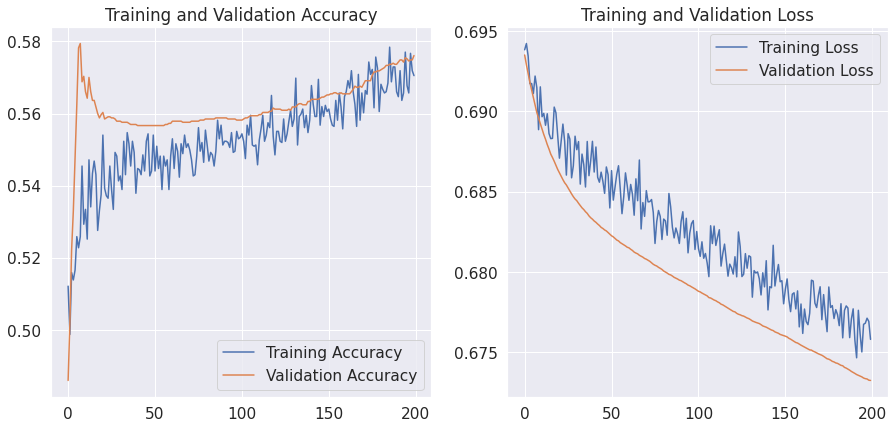

In [44]:
acc = history_pert.history['accuracy']
val_acc = history_pert.history['val_accuracy']
loss = history_pert.history['loss']
val_loss = history_pert.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Confusion Matrix

In [45]:
num_of_train_samples = train_pert_count
num_of_test_samples = val_count
test_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = test_datagen.flow_from_directory("preprocessing/val_data",
                                                        target_size=(224, 224),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')
Y_pred = model_pert.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
confusion_matrix_array = confusion_matrix(validation_generator.classes, y_pred)
print(confusion_matrix_array)
df_cm = pd.DataFrame(confusion_matrix_array, range(2), range(2))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

#### Classification Report

In [49]:
predictions = model_pert.predict_classes(x_val)
predictions = predictions.reshape(1,-1)[0]

target_names = ['Female (Class 0)','Male (Class 1)']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names, zero_division=1))

/home/monash/.pyenv/versions/3.6.13/envs/fyp/lib/python3.6/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                  precision    recall  f1-score   support

Female (Class 0)       0.55      0.95      0.70      1832
  Male (Class 1)       0.41      0.05      0.08      1468

        accuracy                           0.55      3300
       macro avg       0.48      0.50      0.39      3300
    weighted avg       0.49      0.55      0.43      3300



********
## Step 7: Making Predictions

Through analysis of the images below, it seems that when the data is pertubated with make up on, it is more likely that the model will predict that the subject is a female. 

Speculations:
- Adding some make up to classified male faces may improve gender biasness in AI
- Removing make up features from females may improve gender biasness in AI

### Without Pertubation

In [50]:
def predictImage(filename):
    img = tf.keras.preprocessing.image.load_img(filename, target_size=(224, 224))
    input_arr = tf.keras.preprocessing.image.img_to_array(img)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    input_arr = input_arr.astype('float32') / 255.  # This is VERY important
    predictions = model.predict(input_arr)
    val = np.argmax(predictions, axis=-1)
    
    img1 = image.load_img(filename,target_size=(img_size,img_size))
    plt.imshow(img1)
    if val == 1:
        plt.xlabel("MALE",fontsize=30)
    elif val == 0:
        plt.xlabel("FEMALE",fontsize=30)

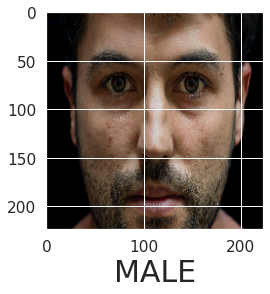

In [57]:
predictImage("random.jpeg")

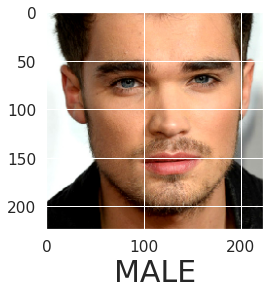

In [65]:
predictImage("celeb.jpg")

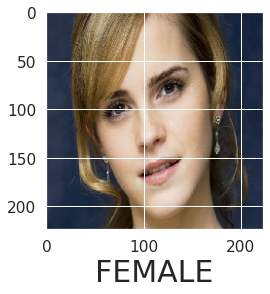

In [66]:
predictImage("emma.jpg")

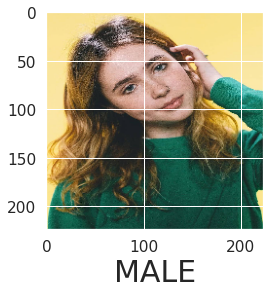

In [53]:
predictImage("clairo.jpeg")

### With Pertubation

In [58]:
def predictImagePert(filename):
    img = tf.keras.preprocessing.image.load_img(filename, target_size=(224, 224))
    input_arr = tf.keras.preprocessing.image.img_to_array(img)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    input_arr = input_arr.astype('float32') / 255.  # This is VERY important
    predictions = model_pert.predict(input_arr)
    val = np.argmax(predictions, axis=-1)
    
    img1 = image.load_img(filename,target_size=(img_size,img_size))
    plt.imshow(img1)
    if val == 1:
        plt.xlabel("MALE",fontsize=30)
    elif val == 0:
        plt.xlabel("FEMALE",fontsize=30)

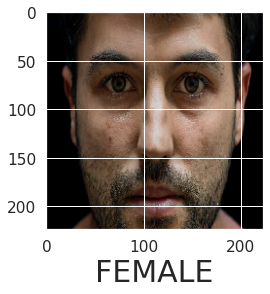

In [62]:
predictImagePert("random.jpeg")

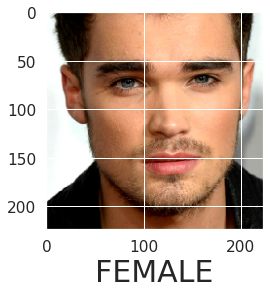

In [68]:
predictImagePert("celeb.jpg")

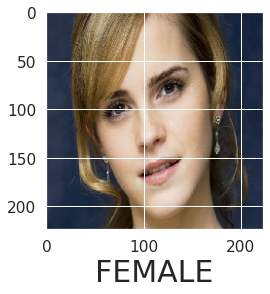

In [67]:
predictImagePert("emma.jpg")

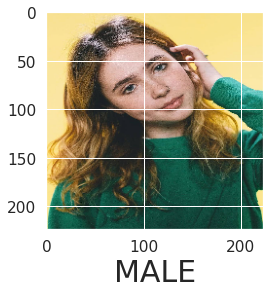

In [61]:
predictImagePert("clairo.jpeg")